<a href="https://colab.research.google.com/github/AfraAd/CSC413-Homeworks/blob/main/Fall25_Hw12_DistributedTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 12

In this homework, we will implement a (simulated) distributed training framework, focusing on how backend communication operates under different parallelism strategies. We will implement two widely used approaches in distributed training: data parallelism and tensor parallelism.

In Section 1, we build a `DistributedContext` class, which coordinates communication across multiple processes (e.g., training steps running on different GPUs). This simulates the role of a real distributed backend such as torch.distributed. However, to keep the assignment lightweight, our setting uses Python threads on a single CPU as though they were running on separate devices.

Using `DistributedContext`, the data parallel and tensor parallel implementations in Sections 2 and 3 will communicate the necessary activations and gradients during the forward and backward passes. For this assignment, we return to the simple MLP model we worked with earlier in the semester so that the focus remains on understanding the communication patterns rather than model complexity.

In [1]:
import copy
import numpy as np

from typing import List
import torch
import torch.nn as nn
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# 0. Setup

Here, we define the SimpleMLP class and the reference_step() to set up a non-distributed baseline for training. reference_step() performs a simple forward and backward pass on a single worker with no communication involved.

We will compare the outputs of the distributed training steps against the outputs of reference_step() to make sure our distributed training implementations produce numerically consistent updates with the non-distributed version.

In [2]:
################## DO NOT CHANGE ##################
class SimpleMLP(nn.Module):
    """Small MLP used as reference model."""
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.lin1 = nn.Linear(d_in, d_hidden, bias=False)
        self.act = nn.GELU()
        self.lin2 = nn.Linear(d_hidden, d_out, bias=False)

    def forward(self, x):
        return self.lin2(self.act(self.lin1(x)))

def reference_step(model, optimizer, x, y, loss_fn=nn.MSELoss()):
    """Single-device forward+backward+step. Returns loss scalar and output."""
    model.train()
    optimizer.zero_grad()
    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Part 1: Communication during parallel training (1 point)

In distributed training setup, we need a context manager to coordinate the sending and receiving of tensors throughout training. Its key role is to collect the corresponding tensors from each worker, aggregate them, and return the aggregated results back to all processes. This class simulates torch.distributed, while differing in important ways. For instance, it uses Python threads and shared memory instead of actual multi-process, multi-GPU communication backends like NCCL, meaning that no real network transfers, device synchronization, or CUDA semantics are involved.

Here, we will implement a simple DistributedContext by completing the all_gather() and all_reduce() functions:

* **all_gather()**: gather all tensors from the workers and return a list of tensors (sorted in the order of the corresponding ranks).
* **all_reduce()**: gather all tensors from the workers, which are then aggregated with a reduction operation. You can only implement the *sum* and *mean* operations in our assignment.

For high-level introduction to the collective operations (all reduce, all gather, etc.):
* https://docs.nvidia.com/deeplearning/nccl/user-guide/docs/usage/collectives.html

In [3]:
class DistributedContext:
    """Lightweight simulation of torch.distributed for threaded workers."""

    def __init__(self, world_size: int):
        self.world_size = world_size
        self.barrier = threading.Barrier(world_size)
        self.barrier_lock = threading.Lock()
        self.all_gather_buffer = {}
        self.all_reduce_buffer = {}

    def all_gather(self, tensor, rank: int, group_id: str) -> List:
        """Gather tensors from workers into a single list"""
        with self.barrier_lock:
            ################## YOUR CODE ##################
            # TODO: Collect the tensors in the self.all_gather_buffer
            # Hint: Use group_id to store the gathered tensors from the rank r;
            #       e.g. self.all_gather_buffer[group_id][r]
            if group_id not in self.all_gather_buffer:
                self.all_gather_buffer[group_id] = {}
            self.all_gather_buffer[group_id][rank] = tensor
            ################################################

        self.barrier.wait() # wait to collect results from all workers

        ################## YOUR CODE ##################
        # TODO: compute the final all-gather tensor to return
        result = [self.all_gather_buffer[group_id][r] for r in range(self.world_size)]
        ################################################

        self.barrier.wait() # wait until result is calculated across all workers

        ## empty the buffer
        if rank == 0:
            with self.barrier_lock:
                del self.all_gather_buffer[group_id]

        return result

    def all_reduce(self, tensor: torch.Tensor, rank: int, group_id: str, op: str) -> torch.Tensor:
        """Sum-reduce tensors across workers."""
        with self.barrier_lock:
            ################## YOUR CODE ##################
            # TODO: collect the tensors in the self.all_reduce_buffers
            #       e.g. self.all_reduce_buffer[group_id][r]
            if group_id not in self.all_reduce_buffer:
                self.all_reduce_buffer[group_id] = {}
            self.all_reduce_buffer[group_id][rank] = tensor
            ################################################

        self.barrier.wait() # wait to collect results from all workers

        if op == 'sum':
        ################## YOUR CODE ##################
        # TODO: compute the final all-reduce tensors to return (summed)
            result = sum(self.all_reduce_buffer[group_id][r] for r in range(self.world_size))
        ################################################

        elif op == 'mean':
        ################## YOUR CODE ##################
        # TODO: compute the final all-reduce tensors to return (averaged)
            result = sum(self.all_reduce_buffer[group_id][r] for r in range(self.world_size)) / self.world_size
        ################################################

        self.barrier.wait() # wait until gathered is done being calculated

        ## empty the buffer
        if rank == 0:
            with self.barrier_lock:
                del self.all_reduce_buffer[group_id]

        return result

Check whether the all_gather and all_reduce functions return the same results across all processes:

For instance, to test the correctness of your all_gather function:

```
num_process = 4
context = DistributedContext(num_process)
x_in = torch.randn(20,16) # some random input

with ThreadPoolExecutor(max_workers=num_process) as executor:
    futures = [executor.submit(context.all_gather, x_in, rank, 'test_allgather') for rank in range(num_process)]
    fin = [f.result() for f in as_completed(futures)]

# Then check the results in the fin

```

# Part 2: Data Parallelism (2 points)

In this section, we will build a simple implementation of data parallel (DP) training.

In data parallel training, the goal is to train with larger effective batch sizes by distributing the batch across multiple workers. Suppose we have a model $M$, dataset $D$, and $n$ GPUs. A batch $B$ is split into $n$ micro-batches $b_1, ..., b_n$, and each micro-batch is processed by one replica of the model ($M_1, M_2, ..., M_n$). Each replica computes its own gradients $G_1, ..., G_n$.

At the end of the backward pass, these gradients are aggregated into a single gradient $G$ and is communicated back to all replicas. After one training step, the effect is (almost!) equivalent to training the full batch $B$ on a single model $M$.

In real-world DP (e.g., PyTorch DistributedDataParallel), each replica receives a different micro-batch, computes gradients locally, and then an all-reduce operation synchronizes the gradients before the optimizer step. In this homework, we simulate $n$-way data parallelism inside a single process by splitting the batch into $n$ chunks and making $n$ asychronous calls to run the model forward and backward steps.

**TODO**
* Implement `split_batch()`: Given a data tensor `x`, the worker `rank`, and the `world_size`, return the correct slice of the batch. You should also handle the case where the batch size is not perfectly divisible by the number of workers.
* Implement `dp_step()`: This simulates the training step for rank-i process. Get a slice of the batch, run forward and backward on the local model copy, call `all_reduce()` to synchronize gradients across processes, apply the optimizer update, and return the loss.
    * In practice, torch's implementation of distributed data parallel uses autograd hooks registered at construction time to trigger gradients synchronizations during the backward pass. However, to simplify the assignment, we simply synchronize all gradients once at the end of the loss computation (TODO 2 and 3 of dp_step).


**NOTE**
* You can read more about torch's distributed data parallelism here: https://docs.pytorch.org/tutorials/intermediate/ddp_tutorial.html


In [4]:
def split_batch(x, rank, world_size):

    ######################## YOUR CODE ########################
    # TODO: Given a tensor of shape (batch_size, input_dimension),
    #       return a microbatch sized (batch_size // world_size, input_dimension)
    #                              or (batch_size // world_size + 1, input_dimension)
    # NOTE: You should also handle the case where data_size % world_size != 0
    #       No examples should be dropped.
    batch_size = x.shape[0]
    base_size = batch_size // world_size
    remainder = batch_size % world_size

    # Workers with rank < remainder get one extra example
    if rank < remainder:
        start_idx = rank * (base_size + 1)
        end_idx = start_idx + base_size + 1
    else:
        start_idx = remainder * (base_size + 1) + (rank - remainder) * base_size
        end_idx = start_idx + base_size

    return x[start_idx:end_idx]
    ###########################################################

In [5]:
def dp_step(rank, world_size, model, optimizer, fullbatch_x, fullbatch_y, dist_context, epoch_num, loss_fn=nn.MSELoss()):

    ######################### YOUR CODE #########################
    # TODO 1: split the batch into a list of minibatches
    minibatch_x = split_batch(fullbatch_x, rank, world_size)
    minibatch_y = split_batch(fullbatch_y, rank, world_size)
    #############################################################

    out = model(minibatch_x)
    loss = loss_fn(out, minibatch_y)
    optimizer.zero_grad()
    loss.backward()

    ######################### YOUR CODE #########################
    # TODO 2: Gather gradients into a single flat vector, and call all_reduce
    #         using dist_context, which is an instance of DistributedContext(world_size)
    #         Define the avg_grad = summed gradient from all processes / total # workers

    # Flatten all gradients into a single vector
    grad_list = []
    for param in model.parameters():
        if param.grad is not None:
            grad_list.append(param.grad.view(-1))  # Flatten to 1D

    # Concatenate all gradients into a single flat tensor
    local_grad = torch.cat(grad_list)

    # All-reduce to get the mean gradient across all workers
    group_id = f"epoch_{epoch_num}_grad"
    avg_grad = dist_context.all_reduce(local_grad, rank, group_id, op='mean')

    ############################################################

    ######################### YOUR CODE #########################
    # TODO 3: Apply the gradient (avg_grad) from the previous step
    #         You can use model.parameters() to iterate through the parameters,
    #         and set parameter gradient = slice of the aggregated gradient

    offset = 0
    for param in model.parameters():
        if param.grad is not None:
            # Calculate the number of elements in this parameter
            numel = param.grad.numel()

            # Extract the corresponding slice from avg_grad
            param.grad.data = avg_grad[offset:offset + numel].view_as(param.grad)

            # Move offset forward
            offset += numel

    ############################################################

    # Once the gradients are propagated, all optimizer.step() updates the params
    optimizer.step()

    return loss.detach().item()

We use `run_dp_process` to launch simulated distributed training. Each process holds its own model replica and optimizer, while communicating through the shared `dist_context`.

In [6]:
########################## DO NOT MODIFY ##########################
def run_dp_process(world_size, x, y, epoch, base_model, step, dist_context):

    models = [copy.deepcopy(base_model) for _ in range(world_size)]
    optimizers = [torch.optim.SGD(m.parameters(), lr=0.05) for m in models]

    dist_context = dist_context(world_size=world_size)

    train_losses = []
    for i in range(epoch):
        with ThreadPoolExecutor(max_workers=world_size) as executor:
            futures = [executor.submit(step,
                                    rank,
                                    world_size,
                                    models[rank],
                                    optimizers[rank],
                                    x, y,
                                    dist_context,
                                    i) for rank in range(world_size)]
            losses = [f.result() for f in as_completed(futures)]

            avg_loss = sum(losses) / len(losses)
            train_losses.append(avg_loss)

    return train_losses

Check that your DP training outcome and non-DP training outcome are the same:

```
epoch = N
world_size=4
x = torch.randn(20,16)
y = torch.rand(20,2)
model = SimpleMLP(16,32,2)

dp_losses = run_dp_process(world_size, x, y, epoch, model, dp_step, DistributedContext)

nondp_losses = []
for i in range(epoch):
    ref_loss = reference_step(model, torch.optim.SGD(model.parameters(), 0.05), x, y)
    nondp_losses.append(ref_loss)

np.allclose(dp_losses[-1], nondp_losses[-1], atol=1e-6)
```

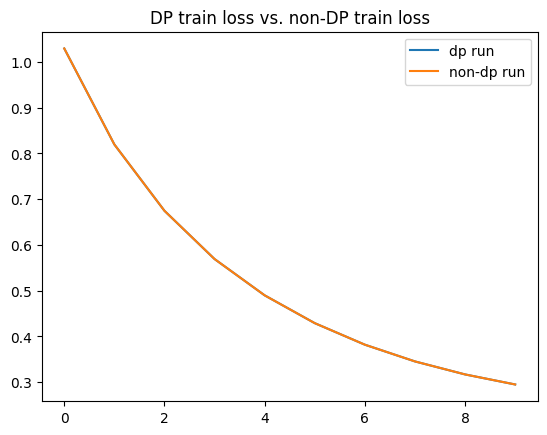

In [7]:
# You can also check that your DP training returns the same loss as the non-Dp training!

if __name__ == '__main__':
    x, y = make_moons(n_samples=200, noise=0.2, random_state=42)
    x = torch.tensor(x).to(torch.float)
    y = torch.tensor(y).to(torch.float).reshape(-1,1)

    world_size = 10
    num_epoch = 10
    base_model = SimpleMLP(2,16,1)
    dp_model = copy.deepcopy(base_model)
    nondp_model = copy.deepcopy(base_model)

    # DP run
    train_losses = run_dp_process(world_size=world_size,
                                           base_model=dp_model,
                                           x=x, y=y,
                                           epoch=num_epoch,
                                           step=dp_step,
                                           dist_context=DistributedContext)

    # non-DP run
    train_losses_ref = []
    for i in range(num_epoch):
        ref_loss = reference_step(nondp_model, torch.optim.SGD(nondp_model.parameters(), 0.05), x, y)
        train_losses_ref.append(ref_loss)

    plt.plot(train_losses, label='dp run')
    plt.plot(train_losses_ref, label='non-dp run')
    plt.title("DP train loss vs. non-DP train loss")
    plt.legend()

# Part 3 TensorParallel Layers (3.5 points)

For tensor parallelism, you need tensor-parallel–specific layers to perform both column-parallel and row-parallel tensor sharding. The advantage of this approach is improved memory efficiency: each process only stores a slice of the full weight matrix instead of the entire layer. As a result, each process also stores proportionally smaller input cache and gradients. However, this comes at the cost of additional communication, since processes must exchange partial results during both the forward and backward passes.

Both layers inherit from the shared TensorParallelLinear base class.

* **ColumnParallelLinear**: A child class of TensorParallelLinear. It splits the full linear layer’s weight matrix along its column dimension, and each process holds a subset of the output features. During the forward pass, each process computes its partial output, and then performs a collective communication step (all-gather) so that the full output tensor becomes globally available.

* **RowParallelLinear**:  A child class of TensorParallelLinear. It splits the weight matrix along its row dimension, and each process holds only the rows relevant to its shard of the input features. Each process computes a partial output from its local rows, and these partial outputs are then combined across processes using an all-reduce so that the full output is reconstructed.

Because the input and output partitions differ across these two sharding schemes, they each require their own specialized *forward()* method. In addition, they need customized *backward()* logic: while gradients w.r.t the sharded weights can be computed locally without communication, gradients w.r.t. the input require an additional communication (e.g., all-reduce for column-parallel layers or all-gather for row-parallel layers). Again, we avoid using autograd and do it the manual way in this assignment.

In [8]:
########################## DO NOT CHANGE ##########################
class TensorParallelLinear(nn.Module):

    def __init__(self,
                 input_size: int,
                 output_size: int,
                 rank: int, world_size: int,
                 dist_context: DistributedContext,
                 ):

        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.rank = rank
        self.world_size = world_size
        self.dist_context = dist_context

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError("Child class must implement backward()")

    def backward(self):
        raise NotImplementedError("Child class must implement backward()")

## Part 3.1: Column-parallel layer (1.5 point)

In [9]:
class ColumnParallelLinear(TensorParallelLinear):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        assert self.output_size % self.world_size == 0
        self.output_size_per_partition = self.output_size // self.world_size
        self.weight = nn.Parameter(torch.randn(self.input_size, self.output_size_per_partition))
        self.input_cache = None
        self.forward_counter = 0
        self.backward_counter = 0

        print(f"  [Rank {self.rank}] initialized column parallel layer, weight shape: {self.weight.shape}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        ############################ YOUR CODE ############################
        # TODO 1: Compute local output using the sharded weight (self.weight)
        #         Store the input cache for backprop later

        # Cache input for backward pass
        self.input_cache = x

        # Compute local output: x @ weight_shard
        # x shape: (batch_size, input_size)
        # self.weight shape: (input_size, output_size_per_partition)
        # local_output shape: (batch_size, output_size_per_partition)
        local_output = x @ self.weight

        # TODO 2: Perform all-gather to collect outputs from all workers;
        #         The final output should be equivalent to the output computed without parallelism.
        if self.world_size > 1:
            # All-gather the outputs from all ranks
            group_id = f"col_forward_{self.forward_counter}"
            gathered_outputs = self.dist_context.all_gather(
                local_output,
                self.rank,
                group_id
            )
            # Concatenate along the feature dimension (columns)
            # gathered_outputs is a list of tensors, one from each rank
            output = torch.cat(gathered_outputs, dim=1)
        else:
            output = local_output

        self.forward_counter += 1
        return output
        ###################################################################

    def backward(self, grad_upstream):

        ############################ YOUR CODE ############################
        # TODO 1: Given the full upstream gradient, only take the gradient corresponding to this shard
        #         The upstream gradient grad_upstream is w.r.t. the full output,
        #         but each rank only needs the parts corresponding to its columns
        #         Hint: use self.rank, self.output_size_per_partition to select the corresponding *columns* of the grad_upstream

        # Extract the gradient slice for this rank's output columns
        start_col = self.rank * self.output_size_per_partition
        end_col = start_col + self.output_size_per_partition
        grad_local_output = grad_upstream[:, start_col:end_col]

        # TODO 2: Compute gradient w.r.t. weights and store the gradient inside self.weight.grad

        # grad_weight = input^T @ grad_output
        # self.input_cache shape: (batch_size, input_size)
        # grad_local_output shape: (batch_size, output_size_per_partition)
        # grad_weight shape: (input_size, output_size_per_partition)
        grad_weight = self.input_cache.T @ grad_local_output
        self.weight.grad = grad_weight

        # TODO 3: output the gradient w.r.t. the input using all-reduce

        # grad_input = grad_output @ weight^T
        # grad_local_output shape: (batch_size, output_size_per_partition)
        # self.weight shape: (input_size, output_size_per_partition)
        # local_grad_input shape: (batch_size, input_size)
        local_grad_input = grad_local_output @ self.weight.T

        if self.world_size > 1:
            # All-reduce to sum gradients from all ranks
            group_id = f"col_backward_{self.backward_counter}"
            grad_input = self.dist_context.all_reduce(
                local_grad_input,
                self.rank,
                group_id,
                op='sum'
            )
        else:
            grad_input = local_grad_input

        self.backward_counter += 1
        ###################################################################

        return grad_input

You can check the correctness of your implementation by launching a threadpool executor:

```
world_size=N
in_features=A
out_features=B
context = DistributedContext(world_size)
x_in = torch.randn(50,in_features)
grad_upstream = torch.ones(50,out_features)

layers = [ColumnParallelLinear(input_size=in_features,output_size=out_features,rank=i,world_size=world_size,dist_context=context) for i in range(world_size)]

with ThreadPoolExecutor(max_workers=world_size) as executor:
    futures = [executor.submit(layers[rank].forward, x_in) for rank in range(world_size)]
    fin_forward = [f.result() for f in as_completed(futures)]

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(layers[rank].backward, grad_upstream) for rank in range(world_size)]
    fin_grad = [f.result() for f in as_completed(futures)]

# check the forward() result and backward() result
```

## 3.2 Row-parallel layer (1.5 points)

In [10]:
class RowParallelLinear(TensorParallelLinear):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        assert self.input_size % self.world_size == 0
        self.input_size_per_partition = self.input_size // self.world_size
        self.weight = nn.Parameter(torch.randn(self.input_size_per_partition, self.output_size))
        self.input_cache = None
        self.forward_counter = 0
        self.backward_counter = 0
        print(f"  [Rank {self.rank}] Initialized row parallel layer, weight shape: {self.weight.shape}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        ############################ YOUR CODE ############################
        # TODO 1: Compute local output using the sharded weight
        #         For row-parallelism, you need to splice the input x
        #         corresponding to the weights
        #         Cache the sliced input used to compute the output

        # Slice the input to match this rank's weight rows
        # x shape: (batch_size, input_size)
        # We need to extract columns [start:end] corresponding to this rank's rows
        start_col = self.rank * self.input_size_per_partition
        end_col = start_col + self.input_size_per_partition
        x_local = x[:, start_col:end_col]

        # Cache the sliced input for backward pass
        self.input_cache = x_local

        # Compute local output: x_local @ weight_shard
        # x_local shape: (batch_size, input_size_per_partition)
        # self.weight shape: (input_size_per_partition, output_size)
        # local_output shape: (batch_size, output_size)
        local_output = x_local @ self.weight

        # TODO 2: Perform all-reduce to collect outputs from all workers;
        #         Again, the final output should be equivalent to the output computed without parallelism.
        if self.world_size > 1:
            # All-reduce with sum to combine partial outputs from all ranks
            group_id = f"row_forward_{self.forward_counter}"
            output = self.dist_context.all_reduce(
                local_output,
                self.rank,
                group_id,
                op='sum'
            )
        else:
            output = local_output

        self.forward_counter += 1
        return output
        ###################################################################

    def backward(self, grad_upstream):

        ############################ YOUR CODE ############################
        # TODO 1: Compute gradient w.r.t. weights and store the gradient inside self.weight.grad
        #         Unlike column-parallel case, row-parallel needs the full grad_upstream
        #         to compute the gradient w.r.t. the weights

        # grad_weight = input^T @ grad_output
        # self.input_cache shape: (batch_size, input_size_per_partition)
        # grad_upstream shape: (batch_size, output_size)
        # grad_weight shape: (input_size_per_partition, output_size)
        grad_weight = self.input_cache.T @ grad_upstream
        self.weight.grad = grad_weight

        # TODO 2: output the gradient w.r.t. the input using all-gather

        # grad_input = grad_output @ weight^T
        # grad_upstream shape: (batch_size, output_size)
        # self.weight shape: (input_size_per_partition, output_size)
        # local_grad_input shape: (batch_size, input_size_per_partition)
        local_grad_input = grad_upstream @ self.weight.T

        if self.world_size > 1:
            # All-gather to collect gradient slices from all ranks
            group_id = f"row_backward_{self.backward_counter}"
            gathered_grads = self.dist_context.all_gather(
                local_grad_input,
                self.rank,
                group_id
            )
            # Concatenate along the feature dimension (columns)
            grad_input = torch.cat(gathered_grads, dim=1)
        else:
            grad_input = local_grad_input

        self.backward_counter += 1
        ###################################################################

        return grad_input

You can test the correctness of your implementation using a similar code snippet as above.

## Part 3.3 Tensor-parallel training (0.5 point)

Just like in the previous section, we will use the tensor-parallel layers from the previous part to train the model. We will also use threading and `tp_step` to instantiates each process, assigns the appropriate weight shards, runs the global forward pass, and then executes the global backward pass by coordinating the partial computations across all workers.

Again, in practice, actual tensor-parallel training does not use threads—each worker runs in its own process, typically one process per GPU.

In this section, you will implement the following functions for you to run the tensor-parallel training:

* replace_to_tp_simple_mlp(): manually maps original model layers to tensor-parallel layers (if it's nn.Linear model, either with ColumnParallelLinear or RowParallelLinear).

We provide the following code to simulate the distributed training:
* tp_step(): a single forward and backward pass using the tensor-parallel model
* run_tp_process(): simulated distributed training environment

In [11]:
########################## DO NOT MODIFY ##########################
def replace_to_tp_simple_mlp(base_model: SimpleMLP,
                             rank: int,
                             world_size: int,
                             dist_context: DistributedContext,
                             tp_map: dict
                             ):

    model = copy.deepcopy(base_model)
    base_modules = dict(base_model.named_modules())

    for name, module in model.named_modules():
        if name not in tp_map:
            continue

        d_in, d_out = module.in_features, module.out_features
        if tp_map[name] == 'column':
            setattr(model, name, ColumnParallelLinear(d_in, d_out, rank, world_size, dist_context))
            output_size_tp = d_out // world_size
            slice_tp = slice(rank * output_size_tp, (rank + 1) * output_size_tp)
            weight_slice = base_modules[name].weight.T[:, slice_tp]

        elif tp_map[name] == 'row':
            setattr(model, name, RowParallelLinear(d_in, d_out, rank, world_size, dist_context))
            output_size_tp = d_in // world_size
            slice_tp = slice(rank * output_size_tp, (rank + 1) * output_size_tp)
            weight_slice = base_modules[name].weight.T[slice_tp, :]

        new_modules = dict(model.named_modules())
        with torch.no_grad():
            new_modules[name].weight.copy_(weight_slice)

    model.layers = [model.lin1, model.act, model.lin2]

    return model

In [12]:
########################## DO NOT MODIFY ##########################
def run_tp_process(world_size, x, y, epoch, base_model, step, dist_context, tp_dict):

    dist_context = dist_context(world_size=world_size)
    models = [replace_to_tp_simple_mlp(base_model, rank, world_size, dist_context, tp_dict)
              for rank in range(world_size)
            ]
    optimizers = [torch.optim.SGD(model.parameters(), 0.05) for model in models]

    train_losses = []
    for i in range(epoch):

        with ThreadPoolExecutor(max_workers=world_size) as executor:
            futures = [executor.submit(step,
                                       rank,
                                       world_size,
                                       models[rank],
                                       optimizers[rank],
                                       x,y,
                                       dist_context,
                                       i) for rank in range(world_size)]
            losses = [f.result() for f in as_completed(futures)]

            avg_loss = sum(losses) / len(losses)
            train_losses.append(avg_loss)

    return train_losses

In [13]:
############################## DO NOT MODIFY ##############################
def tp_step(rank: int,
            world_size: int,
            model,
            optimizer,
            input_data: torch.Tensor,
            target: torch.Tensor,
            dist_context: DistributedContext,
            loss_fn=nn.MSELoss()
            ):

    # Step 1: forward pass
    input_data = input_data.clone().detach()
    target = target.clone().detach()
    output = model.forward(input_data)
    loss = nn.functional.mse_loss(output, target)
    optimizer.zero_grad()

    dist_context.barrier.wait()

    # Step 2: Instead of loss.backward(), perform (manual) gradient back-propagation
    # NOTE:   This is a simple workaround defining a custom autograd function for tensor-parallel operations
    grad = 2 * (output - target) / output.numel()
    for layer in model.layers[::-1]:
        if hasattr(layer, 'backward'):
            grad = layer.backward(grad)

    dist_context.barrier.wait()

    # Step 3: update the model gradient step
    optimizer.step()

    dist_context.barrier.wait()

    return loss.detach().item()

  [Rank 0] initialized column parallel layer, weight shape: torch.Size([2, 16])
  [Rank 0] Initialized row parallel layer, weight shape: torch.Size([16, 1])
  [Rank 1] initialized column parallel layer, weight shape: torch.Size([2, 16])
  [Rank 1] Initialized row parallel layer, weight shape: torch.Size([16, 1])


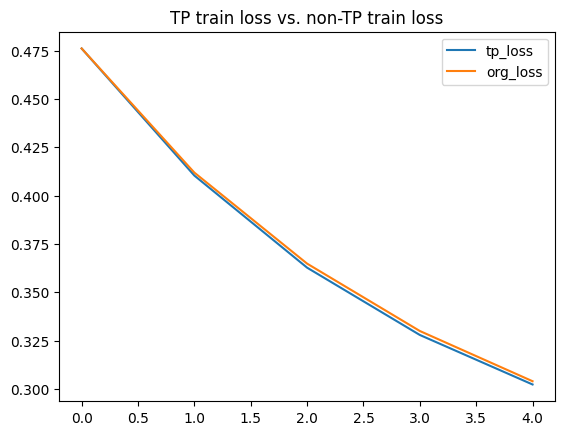

In [14]:
if __name__ == '__main__':
    world_size = 2
    num_epoch = 5
    x, y = make_moons(n_samples=200, noise=0.2, random_state=42)
    x = torch.tensor(x).to(torch.float)
    y = torch.tensor(y).to(torch.float).reshape(-1,1)
    base_model = SimpleMLP(2,32,1)
    tp_model = copy.deepcopy(base_model)
    nontp_model = copy.deepcopy(base_model)
    tp_dict = {'lin1': 'column', 'lin2': 'row'}

    train_losses = run_tp_process(world_size=world_size,
                                  base_model=tp_model,
                                  x=x, y=y,
                                  epoch=num_epoch,
                                  step=tp_step,
                                  dist_context=DistributedContext,
                                  tp_dict=tp_dict
                                  )

    # non-DP run
    train_losses_ref = []
    for i in range(num_epoch):
        ref_loss = reference_step(nontp_model, torch.optim.SGD(nontp_model.parameters(), 0.05), x, y)
        train_losses_ref.append(ref_loss)

    plt.plot(train_losses, label='tp_loss')
    plt.plot(train_losses_ref, label='org_loss')
    plt.title("TP train loss vs. non-TP train loss")
    plt.legend()
